Train a model to recognize handwritten digits using numpy

- Load the MNIST dataset from the web and store as NumPy arrays
- Train a simple model to solve MNIST using PyTorch
- Do the same with NumPy by implementing various ML algorithms

In [158]:
%pylab inline
import numpy as np
from tqdm import trange

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/huwng/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['grid']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [159]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [160]:
# X_train: training images
# Y_train: training labels
# X_test: Test images
# Y_test: test labels

# reshapes data into format where each image is 28x28 pixels
# flatten 2D images in to 1D arrays, with 784 columns
# 60000 as number of images in dataset 748 = 28*28
X_train.reshape(-1, 28*28).shape

(60000, 784)

(<matplotlib.image.AxesImage at 0x28e4d9c50>, 0)

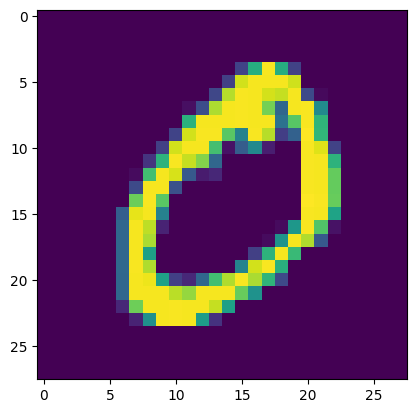

In [161]:
imshow(X_train[1]), Y_train[1]

In [162]:
# model in pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F

# implement in pytorch
class BobNet(torch.nn.Module):
  def __init__(self):
    super(BobNet, self).__init__()
    self.l1 = nn.Linear(784, 128)
    self.l2 = nn.Linear(128,10)
    self.sm = nn.LogSoftmax(dim=1)
    
  def forward(self,x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x
model = BobNet()

In [163]:
X_train.shape

(60000, 28, 28)

In [164]:
# don't be a noob
s = X_train[0:10].reshape(-1,28*28)
float_tensor = torch.tensor(s).float()
mo = model(float_tensor)

In [165]:
np.random.randint(0,100, size=32)

array([ 9, 95, 37, 35, 61, 98,  3, 72, 96, 98, 87, 87, 90, 18, 70, 87,  7,
        3, 77, 72, 67, 88, 77, 81, 72, 22,  1, 78, 86, 90, 63, 25])

loss 0.28 accuracy 0.88: 100%|██████████| 1000/1000 [00:00<00:00, 1067.22it/s]


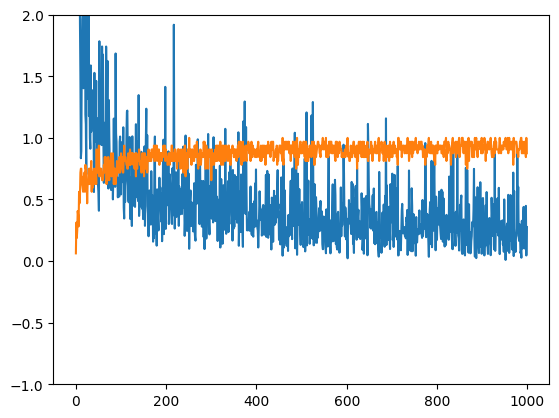

In [166]:
# quick training loop model
BS = 32
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
# what's SGD? what's learning rate?

losses, accuracies = [], []

for i in (t:= trange(1000)):
  samp = np.random.randint(0,X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1,28*28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  optim.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat==Y).float().mean()
  # crossentropyloss class?
  loss = loss_func(out, Y)
  # back propagation
  loss.backward()
  # torch optimizer? adam?
  # updates the weights of the neural network to minimize the loss function
  # adam is automatically adjusts the learning rate during training and often performs well in practice
  # zero_grad. george forgot to do that in 1 of example lol
  optim.step()

  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)

  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-1,2)
plot(losses)
plot(accuracies)

In [167]:
# evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9187

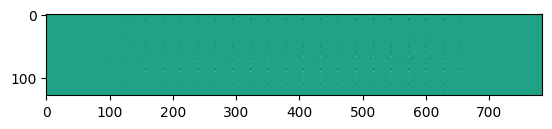

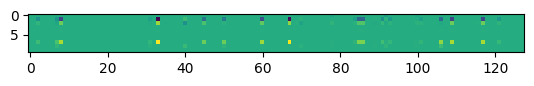

In [168]:
# compute gradients in torch
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_func(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

# From Scratch!
Goal is to have the same result as pytorch

In [169]:
# init the network
# what's linear layer? what's relu?
# why float32?
# why twist the shape?
l1 = np.zeros((128,784), dtype=np.float32)
l2 = np.zeros((10, 128), dtype=np.float32)

l1.dtype, l2.dtype, id(l1), id(l2)

(dtype('float32'), dtype('float32'), 10989609072, 10968417168)

In [170]:
model.l1.weight

Parameter containing:
tensor([[ 0.0181,  0.0136, -0.0238,  ...,  0.0355,  0.0204, -0.0002],
        [ 0.0233,  0.0279,  0.0146,  ..., -0.0243,  0.0021, -0.0166],
        [ 0.0082, -0.0143,  0.0320,  ...,  0.0120,  0.0007,  0.0036],
        ...,
        [-0.0099, -0.0029, -0.0057,  ..., -0.0099, -0.0346,  0.0023],
        [ 0.0032, -0.0139, -0.0340,  ...,  0.0293, -0.0052,  0.0166],
        [ 0.0256,  0.0025,  0.0029,  ..., -0.0115, -0.0306,  0.0227]],
       requires_grad=True)

In [171]:
# copy weights from pytorch

l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

### forward

In [172]:
# numpy forward pass
# a NN with 2 layers
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)  
    return x

def np_eval():
    Y_test_preds_out = forward(X_test.reshape((-1,28*28)))
    # predicted labels for test set
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1) # select the index of the max value in each row
    return (Y_test == Y_test_preds).mean() # acc
np_eval()
# Y_test_preds_out = forward(X_test.reshape((-1,28*28)))    


0.9194

In [173]:
print(np.log(np.exp(Y_test_preds_out[0]).sum()))

# what does x[class] mean?
print(Y_test[0])

print(Y_test_preds_out[0,7])

-Y_test_preds_out[0, 7] + np.log(np.exp(Y_test_preds_out[0]).sum())

20.255411
7
20.2554


1.1444092e-05

In [174]:
samp = 1
-Y_test_preds_out[samp, Y_test[samp]] + np.log(np.exp(Y_test_preds_out[samp]).sum())

0.00046539307

In [175]:
# arrayiyfied
-np.array([Y_test_preds_out[i, Y_test[i]] for i in range(Y_test_preds_out.shape[0])]) + np.log(np.exp(Y_test_preds_out).sum(axis=1))

array([1.1444092e-05, 4.6539307e-04, 6.1893463e-04, ..., 2.4604797e-04,
       3.9863586e-04, 1.3351440e-05], dtype=float32)

In [176]:
# howw?
print(np.array([Y_test_preds_out[i, Y_test[i]] for i in range(Y_test_preds_out.shape[0])]))
Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test]

[20.2554    18.948643  10.336095  ... 13.265679   7.1525135 16.919386 ]


array([20.2554   , 18.948643 , 10.336095 , ..., 13.265679 ,  7.1525135,
       16.919386 ], dtype=float32)

In [177]:
ret = -Y_test_preds_out[range(Y_test_preds_out.shape[0]), Y_test] + np.log(np.exp(Y_test_preds_out).sum(axis=1))

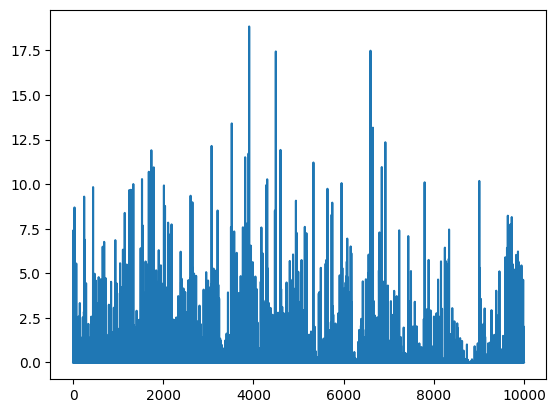

In [178]:
plot(ret)

3906
18.84097
1


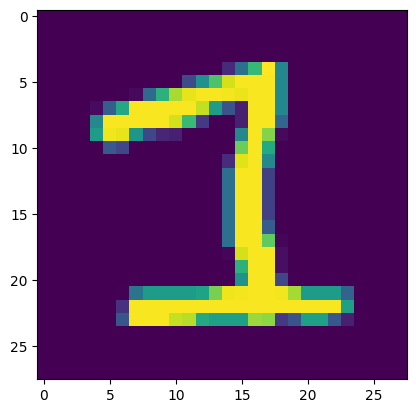

In [179]:
# highest uncertainty
print(np.argmax(ret))
print(ret[np.argmax(ret)])
print(Y_test[np.argmax(ret)])
imshow(X_test[np.argmax(ret)])


3906
13.405101
6


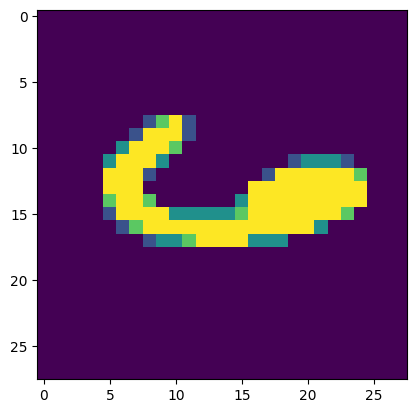

In [180]:
# how come this has the higher uncertainty than the above one?
print(np.argmax(ret))
print(ret[3520])
print(Y_test[3520])
imshow(X_test[3520])

In [181]:
# top 10 highest uncertainty
sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[:10]

[(18.84097, 3906),
 (17.4817, 6597),
 (17.439903, 4497),
 (13.405101, 3520),
 (13.167176, 6651),
 (12.348782, 6926),
 (12.142763, 3073),
 (11.91956, 4601),
 (11.89943, 1737),
 (11.721492, 3893)]

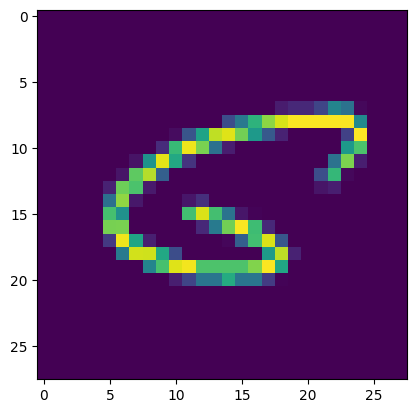

In [182]:
imshow(X_test[1014])

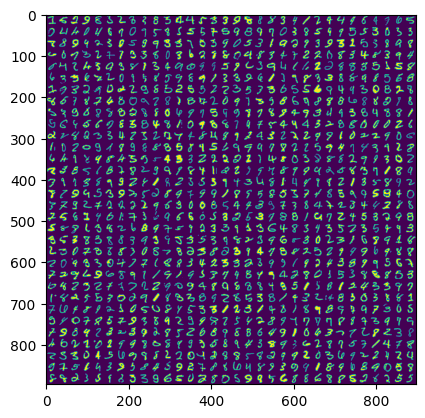

In [183]:
# grid of images
G = 32
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
imshow(np.concatenate(X_bad.reshape((G, 28*G, 28)), axis=1))

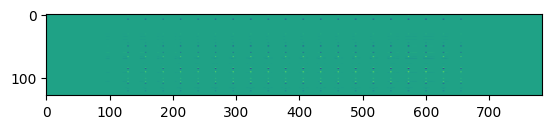

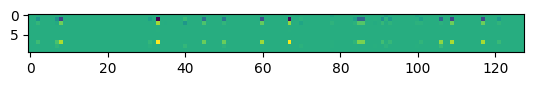

In [184]:
def logsumexp(x):
    #TODO: why?
    c = x.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

# np forward backward pass
def forward_backward(x,y):
    out = np.zeros((len(y),10), np.float32)
    out[range(out.shape[0]),y] = 1
    
    # foward
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))   
    x_loss = (-out * x_lsm).mean(axis=1)
    
    # backward
    d_out = -out / len(y)
    dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))
    
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)
    
    # derivative relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    
    d_l1 = x.T.dot(dx_l1)
    
    return x_loss, x_l2, d_l1, d_l2


    
    

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)

loss 0.01 accuracy 0.99: 100%|██████████| 1000/1000 [00:10<00:00, 98.84it/s]


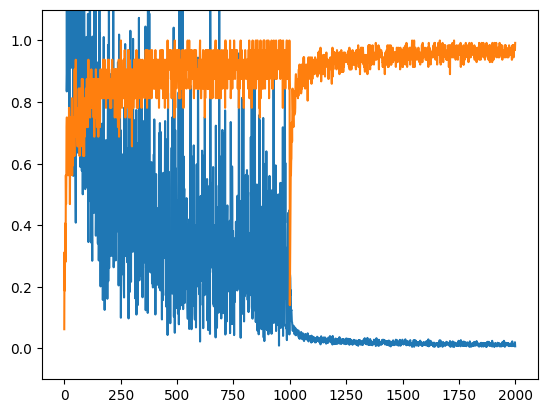

In [185]:
def layer_init(m, h):
  ret = np.random.uniform(-1., 1., size=(m,h)) / np.sqrt(m * h)
  return ret

# putting it all together

np.random.seed(6969)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
for i in (t:= trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = Y_train[samp]
    
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
    
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
    
    # sgd
    l1 = l1 - lr*d_l1
    l2 = l2 - lr*d_l2
    
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [186]:
np_eval()

0.9644